#### Executing this notebook depends on the Delta tables from project 1 being saved in DBFS!
In project 1, make sure to run chapters 1, 2, 3 fully to save the Delta tables.

#### Also make sure you have GraphFrames installed on the cluster!
https://spark-packages.org/package/graphframes/graphframes

(Choose the correct versions of Spark and Scala!)

In [0]:
# For visualization, also install NetworkX.
# Installing NetworkX via jar didn't work for me so here I install it via pip.
%pip install networkx

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pyspark.sql.functions as F
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import graphframes as gf
import networkx as nx

spark.conf.set("spark.sql.shuffle.partitions", sc.defaultParallelism) #shuffle partitions for faster processing of graph algorithms

### Read DFs

In [0]:
split = 0 # or 'full' to use all data. In that case, queries work but analytics crash because the graph is too big.

# Make sure the table paths here match with the paths in the project 1 notebook (end of chapter 3).
dblp_df = spark.read.load(f'dbfs:/user/dblpv13/dblp_{split}')
author_df = spark.read.load(f'dbfs:/user/dblpv13/authors_{split}')
org_df = spark.read.load(f'dbfs:/user/dblpv13/orgs_{split}')
venue_df = spark.read.load(f'dbfs:/user/dblpv13/venues_{split}')

logger.info(f'Read table row counts:\n\tDBLP fact table: {dblp_df.count()}\n\tAuthor table: {author_df.count()}\n\tVenue table: {venue_df.count()}\n\tOrganization table: {org_df.count()}')

INFO:__main__:Read table row counts:
	DBLP fact table: 77009
	Author table: 144390
	Venue table: 8418
	Organization table: 5370


In [0]:
def lim_print(df, lim = 10): # print only top n (default 10) rows of a dataframe
    display(df.limit(lim))

In [0]:
lim_print(dblp_df)

ID,Venue,Org,Authors,References,Keywords,FOS,Title,Lang,PageStart,PageEnd,DOI,ISBN,Volume,Issue
53e99784b7602d9701f3f5fe,572de199d39c4f49934b3d5c,5f71b2e91c455f439fe3f23f,List(53f46a22dabfaee0d9c3d5e5),"List(53e9a073b7602d9702957efa, 53e9ad87b7602d970377bfb5, 53e9be51b7602d9704b11381, 53e9be04b7602d9704abb31d, 53e9992bb7602d9702169236, 53e998cdb7602d97021044db, 53e9afa6b7602d97039f6054, 53e99822b7602d9702044e60)","List(resource allocation, cpu utilization, quality of service)","List(Virtualization, Service level objective, Virtual machine, Computer science, Testbed, Quality of service, Provisioning, Resource allocation, Web application, Operating system, Distributed computing)",Research on resource allocation for multi-tier web applications in a virtualization environment,en,506,512,10.1007/s11704-011-0127-6,null,5,4
53e99792b7602d9701f5af35,54825226582fc50b5e05610e,5f71b2bd1c455f439fe3dea6,"List(53f43a51dabfaec22baa659b, 53f3b3ffdabfae4b34b2dae9, 53f4333fdabfaeb22f451979)","List(53e9b6eeb7602d970427df40, 53e9b6eeb7602d9704283b9f, 53e9b40eb7602d9703f01b25, 53e9a3c0b7602d9702ccdfc9, 53e99818b7602d97020347a2, 53e9a2acb7602d9702bb4d7e, 558aa7ea84ae84d265bee194, 558a5258e4b037c08756714c, 53e9b946b7602d97045336a9, 53e9b1d6b7602d9703c67695, 53e9a516b7602d9702e3bcea, 53e9ac33b7602d97035f892c, 53e9ba22b7602d9704628817, 53e9af3ab7602d97039769c8, 53e9b1a3b7602d9703c2c6f7, 53e9ac89b7602d9703660f90, 53e9ad2db7602d970370e8a2, 53e9a735b7602d970306db2b, 53e99960b7602d97021a17da)","List(Feature location, Distributed systems, Software reconnaissance)","List(Data mining, Causality, End user, Ranking, Computer science, Military systems, Software, Feature model, Component-based software engineering, A-weighting, Distributed computing)",An approach to feature location in distributed systems,en,57,68,10.1016/j.jss.2004.12.018,null,79,1
53e99792b7602d9701f5b0ed,53a727f720f7420be8ba3092,5f71b6101c455f439fe555a5,List(542a6734dabfae646d55cc87),"List(53e99cbbb7602d970256c4af, 53e9b092b7602d9703afec3f, 53e9b089b7602d9703af06a7, 53e9ae9cb7602d97038c0529, 53e9b5f3b7602d9704144753, 558aac78e4b0b32fcb3831b7, 53e9bc3bb7602d97048b1ed7, 53e9b7b4b7602d970435c58f, 53e9b672b7602d97041db0b8, 53e9b96eb7602d970455d792, 53e9ae97b7602d97038ba7dd, 53e9adf7b7602d97038042d9, 53e9bd6ab7602d9704a0644e)","List(knowledge discovery grid, dynamic grid environment, high performance data mining, parallel optimization method, grid feature, high performance ddm application, data mining grid, decomposing data mining application, data mining parallelization, data intensive computing problem, computational grid environment, data mining application, knowledge discovery, distributed computing, data mining, data intensive computing, parallelization, grid computing, directed acyclic graph)","List(Data mining, Data stream mining, Grid computing, Data-intensive computing, Computer science, Directed acyclic graph, Semantic grid, Knowledge extraction, Business process discovery, Grid, Distributed computing)",A Uniform Parallel Optimization Method for Knowledge Discovery Grid,en,306,312,10.1007/978-3-540-85565-1_38,null,5178,null
53e99792b7602d9701f5b119,0377-2217,5f71b29c1c455f439fe3d0d7,"List(5630ff9645cedb3399c3ca55, 53f4371cdabfaec22ba8766f, 54867430dabfae9b40133dc3)","List(53e9bd50b7602d97049e3238, 573695926e3b12023e4b23a9, 53e9af87b7602d97039cdb54, 53e99876b7602d97020b2192, 53e9bbf5b7602d9704850823, 5c7965584895d9cbc6430efd, 53e9ab42b7602d97034d404d, 5b67376bab2dfb7a20258e8e)","List(Location, Fire stations, Multi-objective programming, Genetic algorithm, Fuzzy programming)","List(Objective programming, Fire protection, Computer science, Fuzzy logic, Operations research, Fire risk, Genetic algorithm, Decision maker)",A fuzzy multi-objective programming for optimization of fire station locations through genetic algorithms,en,903,915,10.1016/j.ejor.2006.07.003,null,181,2
53e99792b7602d9701f5b140,5550376d7cea80f9541873d5,5f71b2f61c455f439fe3f847,List(56017d4445cedb3395e638f7),"List(53e9a2c8b

### The structure of our graph
We use a single GraphFrame in this project. See the **Vertices** and **Edges** chapters for details.

Also, check out the illustration of the structure: https://github.com/Martin-Msb/bdm-project-2/blob/main/sample.png

### Vertices
* Needs to contain column **id**

To each DF, we add the vertex type. We will have 4 types of vertices: publications, authors, organizations, venues.

In [0]:
# Add type to each df.
dblp_df = dblp_df.withColumn('Type', F.lit('publication')).withColumnRenamed('ID', 'id')
author_df = author_df.withColumn('Type', F.lit('author')).withColumnRenamed('ID', 'id')
org_df = org_df.withColumn('Type', F.lit('org')).withColumnRenamed('ID', 'id')
venue_df = venue_df.withColumn('Type', F.lit('venue')).withColumnRenamed('ID', 'id')

# Union the relevant columns of each df into a single df.
_vertices = (dblp_df
             .withColumnRenamed('Title', 'Name')
             .select('id', 'Type', 'Name')
             .union(author_df
                    .select('id', 'Type', 'Name'))
             .union(org_df
                    .select('id', 'Type', 'Name'))
             .union(venue_df
                    .select('id', 'Type', 'Name')))

In [0]:
lim_print(_vertices)

id,Type,Name
53e99784b7602d9701f3f5fe,publication,Research on resource allocation for multi-tier web applications in a virtualization environment
53e99792b7602d9701f5af35,publication,An approach to feature location in distributed systems
53e99792b7602d9701f5b0ed,publication,A Uniform Parallel Optimization Method for Knowledge Discovery Grid
53e99792b7602d9701f5b119,publication,A fuzzy multi-objective programming for optimization of fire station locations through genetic algorithms
53e99792b7602d9701f5b140,publication,Adaptive presentation of evolving information using XML
53e99792b7602d9701f5b19a,publication,Testing the stability of the functional autoregressive process
53e99792b7602d9701f5b1ba,publication,Generating novel tactics through evolutionary computation
53e99792b7602d9701f5b1e7,publication,Robustness of centipede-inspired millirobot locomotion to leg failures.
53e99792b7602d9701f5b2b3,publication,A platform for dynamic microcell redeployment in massively multiplayer online games
53e99792b7602d9701f5b2bc,publication,Persistent detection and recovery of state inconsistencies


### Edges
* Needs to contain columns **src** and **dst**

We will have 4 kinds of relationships: 
* isAuthorOf (Author -> Publication)
* cites (Publication -> Publication)
* hosts (Venue -> Publication)
* worksFor (Author -> Organization)

#### isAuthorOf

In [0]:
# Source is exploded dblp.Authors
# Destination is dblp.id
isAuthorOf_edges = (dblp_df
                    .withColumn('src', F.explode(dblp_df.Authors))
                    .withColumnRenamed('id', 'dst')
                    .withColumn('Type', F.lit('isAuthorOf'))
                    .select('src', 'Type', 'dst'))

In [0]:
lim_print(isAuthorOf_edges)

src,Type,dst
53f46a22dabfaee0d9c3d5e5,isAuthorOf,53e99784b7602d9701f3f5fe
53f43a51dabfaec22baa659b,isAuthorOf,53e99792b7602d9701f5af35
53f3b3ffdabfae4b34b2dae9,isAuthorOf,53e99792b7602d9701f5af35
53f4333fdabfaeb22f451979,isAuthorOf,53e99792b7602d9701f5af35
542a6734dabfae646d55cc87,isAuthorOf,53e99792b7602d9701f5b0ed
5630ff9645cedb3399c3ca55,isAuthorOf,53e99792b7602d9701f5b119
53f4371cdabfaec22ba8766f,isAuthorOf,53e99792b7602d9701f5b119
54867430dabfae9b40133dc3,isAuthorOf,53e99792b7602d9701f5b119
56017d4445cedb3395e638f7,isAuthorOf,53e99792b7602d9701f5b140
54301e81dabfaeca69bca10d,isAuthorOf,53e99792b7602d9701f5b19a


#### cites

In [0]:
# Source is dblp.id
# Destination is exploded dblp.References
cites_edges = (dblp_df
               .withColumn('dst', F.explode(dblp_df.References))
               .withColumnRenamed('id', 'src')
               .withColumn('Type', F.lit('cites'))
               .select('src', 'Type', 'dst'))

#### hosts

In [0]:
# Source is dblp.Venue
# Destination is dblp.id
hosts_edges = (dblp_df
               .withColumnRenamed('id', 'dst')
               .withColumnRenamed('Venue', 'src')
               .withColumn('Type', F.lit('hosts'))
               .select('src', 'Type', 'dst'))

#### worksFor

In [0]:
# Source is the first author of each publication
# Destination is the org of that publication
worksFor_edges = (dblp_df
                  .withColumn('src', dblp_df.Authors.getItem(0))
                  .withColumnRenamed('Org', 'dst')
                  .withColumn('Type', F.lit('worksFor'))
                  .select('src', 'Type', 'dst'))

Let's combine the edges into one DF.

In [0]:
_edges = isAuthorOf_edges.union(cites_edges).union(hosts_edges).union(worksFor_edges)

In [0]:
lim_print(_edges)

src,Type,dst
53f46a22dabfaee0d9c3d5e5,isAuthorOf,53e99784b7602d9701f3f5fe
53f43a51dabfaec22baa659b,isAuthorOf,53e99792b7602d9701f5af35
53f3b3ffdabfae4b34b2dae9,isAuthorOf,53e99792b7602d9701f5af35
53f4333fdabfaeb22f451979,isAuthorOf,53e99792b7602d9701f5af35
542a6734dabfae646d55cc87,isAuthorOf,53e99792b7602d9701f5b0ed
5630ff9645cedb3399c3ca55,isAuthorOf,53e99792b7602d9701f5b119
53f4371cdabfaec22ba8766f,isAuthorOf,53e99792b7602d9701f5b119
54867430dabfae9b40133dc3,isAuthorOf,53e99792b7602d9701f5b119
56017d4445cedb3395e638f7,isAuthorOf,53e99792b7602d9701f5b140
54301e81dabfaeca69bca10d,isAuthorOf,53e99792b7602d9701f5b19a


### Build the GraphFrame

In [0]:
logger.info(f'The graph has {_vertices.count()} vertices and {_edges.count()} edges.')
_graph = gf.GraphFrame(_vertices, _edges)

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection
INFO:__main__:The graph has 235187 vertices and 1281352 edges.


### Queries (Motif-finding)
In every query, there is a "special" vertex - the vertex which is the base of the query.

In [0]:
# Functions for drawing nice graphs.

def find_color(id2Type, color_map, special_vertex, v):
    if (special_vertex is not None) and (v == special_vertex):
        return color_map['special']
    
    type = id2Type[id2Type['id'] == v]['Type'].values[0]
    
    return color_map[type]

# Based on https://stackoverflow.com/a/57784880
def add_edges(g, df, edge_colnames):
    df_pandas = df.toPandas()

    # Iterate over the columns and rows.
    # From each row, add an edge with the src and dst.
    for colname in edge_colnames:
        for row in df_pandas[colname]:
            g.add_edge(row['src'], row['dst'])

def plot_graph(df, edge_colnames, special_vertex = None):
    """ Inputs: 
            df - DataFrame of the graph you want to plot 
            edge_colnames - iterable of df column names that hold the edges of the graph
            special_vertex - id of the vertex we want to color yellow (special color)
    """
    g = nx.DiGraph()
    
    add_edges(g, df, edge_colnames)
       
    # Get only the vertices columns from the df.
    vertices = df.select([c for c in df.columns if c not in edge_colnames])
    
    id2Type = (vertices
               .withColumn('collected', F.array(vertices.columns))
               .withColumn('exploded', F.explode(F.col('collected')))
               .withColumn('id', F.col('exploded.id'))
               .withColumn('Type', F.col('exploded.Type'))
               .select('id', 'Type')
               .distinct()).toPandas()
    
    color_map = {'publication': '#f54040', 
                 'venue': '#d40ee6', 
                 'org': '#77e637', 
                 'special': '#fcbd00', 
                 'author': '#1da6f5'}
            
    plt.figure(figsize=(13, 13))  
    nx.draw(g, node_color = [find_color(id2Type, color_map, special_vertex, v) for v in g])
    plt.legend(handles = [Line2D([0], [0], marker='o', color='#f54040', label='publication', markerfacecolor='#f54040', markersize=15), 
                          Line2D([0], [0], marker='o', color='#d40ee6', label='venue', markerfacecolor='#d40ee6', markersize=15), 
                          Line2D([0], [0], marker='o', color='#77e637', label='org', markerfacecolor='#77e637', markersize=15), 
                          Line2D([0], [0], marker='o', color='#1da6f5', label='author', markerfacecolor='#1da6f5', markersize=15), 
                          Line2D([0], [0], marker='o', color='#fcbd00', label='special', markerfacecolor='#fcbd00', markersize=15)])
    plt.show()

**Co-authorship network of an author. Given an Author's id, find all of the authors they have published some work with.**

In [0]:
co_authors = (_graph
              .filterEdges('Type == "isAuthorOf"')
              .find('(a)-[e1]->(b); (c)-[e2]->(d)')
              .filter('a.id == "548a3169dabfae9b40134ff7" and c.id != a.id and b.id == d.id')) # Put the author ID here

display(co_authors)

a,e1,b,c,e2,d
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e99842b7602d9702071027)","List(53e99842b7602d9702071027, publication, Multi-resolution relaxation)","List(53f44cb1dabfaee1c0b06357, author, K.A. Narayanan)","List(53f44cb1dabfaee1c0b06357, isAuthorOf, 53e99842b7602d9702071027)","List(53e99842b7602d9702071027, publication, Multi-resolution relaxation)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e99842b7602d9702071027)","List(53e99842b7602d9702071027, publication, Multi-resolution relaxation)","List(53f58e0adabfaed748f8045b, author, Dianne P. O'Leary)","List(53f58e0adabfaed748f8045b, isAuthorOf, 53e99842b7602d9702071027)","List(53e99842b7602d9702071027, publication, Multi-resolution relaxation)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e99809b7602d9702020cd4)","List(53e99809b7602d9702020cd4, publication, Convex Digital Solids)","List(53f46220dabfaefedbb78400, author, Chul E. Kim)","List(53f46220dabfaefedbb78400, isAuthorOf, 53e99809b7602d9702020cd4)","List(53e99809b7602d9702020cd4, publication, Convex Digital Solids)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e9986eb7602d97020ab437)","List(53e9986eb7602d97020ab437, publication, Local operations on labelled dot patterns)","List(54055856dabfae91d3fd78c8, author, Jean-Michel Jolion)","List(54055856dabfae91d3fd78c8, isAuthorOf, 53e9986eb7602d97020ab437)","List(53e9986eb7602d97020ab437, publication, Local operations on labelled dot patterns)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e99967b7602d97021aa069)","List(53e99967b7602d97021aa069, publication, Supportedness and tameness differentialless geometry of plane curves)","List(5441156edabfae805a7288b8, author, Longin Jan Latecki)","List(5441156edabfae805a7288b8, isAuthorOf, 53e99967b7602d97021aa069)","List(53e99967b7602d97021aa069, publication, Supportedness and tameness differentialless geometry of plane curves)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e99818b7602d9702030247)","List(53e99818b7602d9702030247, publication, Reconfigurable Cellular Computers)","List(53f43a19dabfaee2a1d08e17, author, Angela Y. Wu)","List(53f43a19dabfaee2a1d08e17, isAuthorOf, 53e99818b7602d9702030247)","List(53e99818b7602d9702030247, publication, Reconfigurable Cellular Computers)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e998dbb7602d9702114919)","List(53e998dbb7602d9702114919, publication, Computation of geometric properties from the medial axis transform in (O(nlogn) time.)","List(53f42ce1dabfaee2a1c74452, author, S.K. Bhaskar)","List(53f42ce1dabfaee2a1c74452, isAuthorOf, 53e998dbb7602d9702114919)","List(53e998dbb7602d9702114919, publication, Computation of geometric properties from the medial axis transform in (O(nlogn) time.)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e998dbb7602d9702114919)","List(53e998dbb7602d9702114919, publication, Computation of geometric properties from the medial axis transform in (O(nlogn) time.)","List(53f43a19dabfaee2a1d08e17, author, Angela Y. Wu)","List(53f43a19dabfaee2a1d08e17, isAuthorOf, 53e998dbb7602d9702114919)","List(53e998dbb7602d9702114919, publication, Computation of geometric properties from the medial axis transform in (O(nlogn) time.)"
"List(548a3169dabfae9b40134ff7, author, Azriel Rosenfeld)","List(548a3169dabfae9b40134ff7, isAuthorOf, 53e9986eb7602d97020a661c)","List(53e9986eb7602d97020a661c, publication, Topology-preserving deformations of two-valued digital pictures)","List(53f433e2dabfaee1c0a84d8a, author, T. Yung Kong)","List(53f433e2dabfaee1c0a84d8a, isAuthorOf, 53e9986eb7602d97020a661c)","List(53e99

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


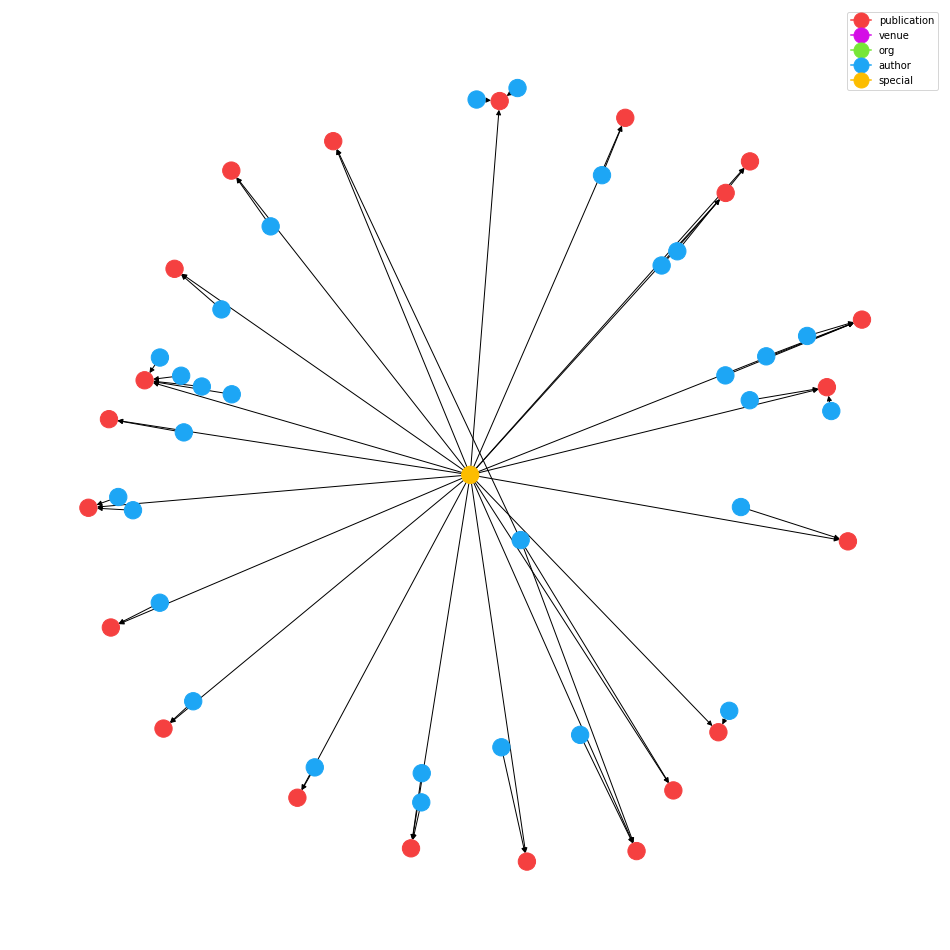

In [0]:
plot_graph(co_authors, ('e1', 'e2'), '548a3169dabfae9b40134ff7') # Copy the author id from the previous cell

We can see that this author has published 21 papers and he's never published a paper alone. Always with at least one co-author.

**Given an org ID, find which authors work for that org.**

In [0]:
org_authors = (_graph
             .filterEdges('Type = "worksFor"')
             .find('(a)-[e]->(b)')
             .filter("b.id == '5f71b2e91c455f439fe3f23f'"))
#c.Type = 'author'

In [0]:
display(org_authors)

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


a,e,b
"List(53f4d37fdabfaef204f80f01, author, Zunshui Cheng)","List(53f4d37fdabfaef204f80f01, worksFor, 5f71b2e91c455f439fe3f23f)","List(5f71b2e91c455f439fe3f23f, org, School of Mathematics and Physics, Qingdao University of Science and Technology, Qingdao, China 266061)"
"List(53f46a22dabfaee0d9c3d5e5, author, Shuguo Yang)","List(53f46a22dabfaee0d9c3d5e5, worksFor, 5f71b2e91c455f439fe3f23f)","List(5f71b2e91c455f439fe3f23f, org, School of Mathematics and Physics, Qingdao University of Science and Technology, Qingdao, China 266061)"


INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


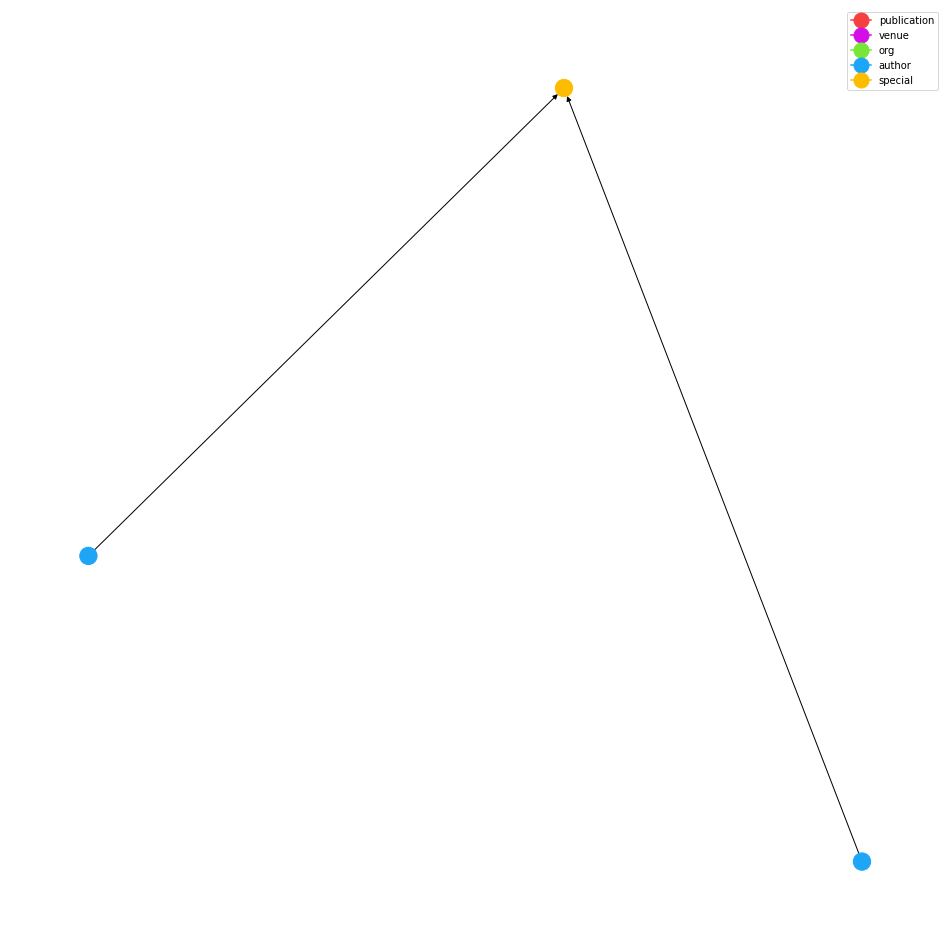

In [0]:
plot_graph(org_authors, ('e'), '5f71b2e91c455f439fe3f23f')

We can visually see that two different authors work for the same organization

**Given a publication ID, what organizations have the authors of this publication worked for.**

In [0]:
pub_orgs = (_graph
            .filterEdges('Type == "isAuthorOf" or Type == "worksFor"')
            .find('(auth1)-[e1]->(pub); (auth2)-[e2]->(org)')
            .filter('pub.id == "53e99a0fb7602d9702263284" and e1.Type == "isAuthorOf" and auth1.id == auth2.id and e2.Type == "worksFor"') # Put the publication ID here
            .distinct())
               
display(pub_orgs)

auth1,e1,pub,auth2,e2,org
"List(53f434c2dabfaee2a1cd7352, author, Guohong Cao)","List(53f434c2dabfaee2a1cd7352, isAuthorOf, 53e99a0fb7602d9702263284)","List(53e99a0fb7602d9702263284, publication, pDCS: Security and Privacy Support for Data-Centric Sensor Networks)","List(53f434c2dabfaee2a1cd7352, author, Guohong Cao)","List(53f434c2dabfaee2a1cd7352, worksFor, 5f71b2d91c455f439fe3eb4f)","List(5f71b2d91c455f439fe3eb4f, org, Department of Physics,The Pennsylvania State University,University Park,USA)"
"List(542a57f9dabfae646d55346a, author, Min Shao)","List(542a57f9dabfae646d55346a, isAuthorOf, 53e99a0fb7602d9702263284)","List(53e99a0fb7602d9702263284, publication, pDCS: Security and Privacy Support for Data-Centric Sensor Networks)","List(542a57f9dabfae646d55346a, author, Min Shao)","List(542a57f9dabfae646d55346a, worksFor, 5f71b2831c455f439fe3c634)","List(5f71b2831c455f439fe3c634, org, Microsoft Research, Redmond, WA)"


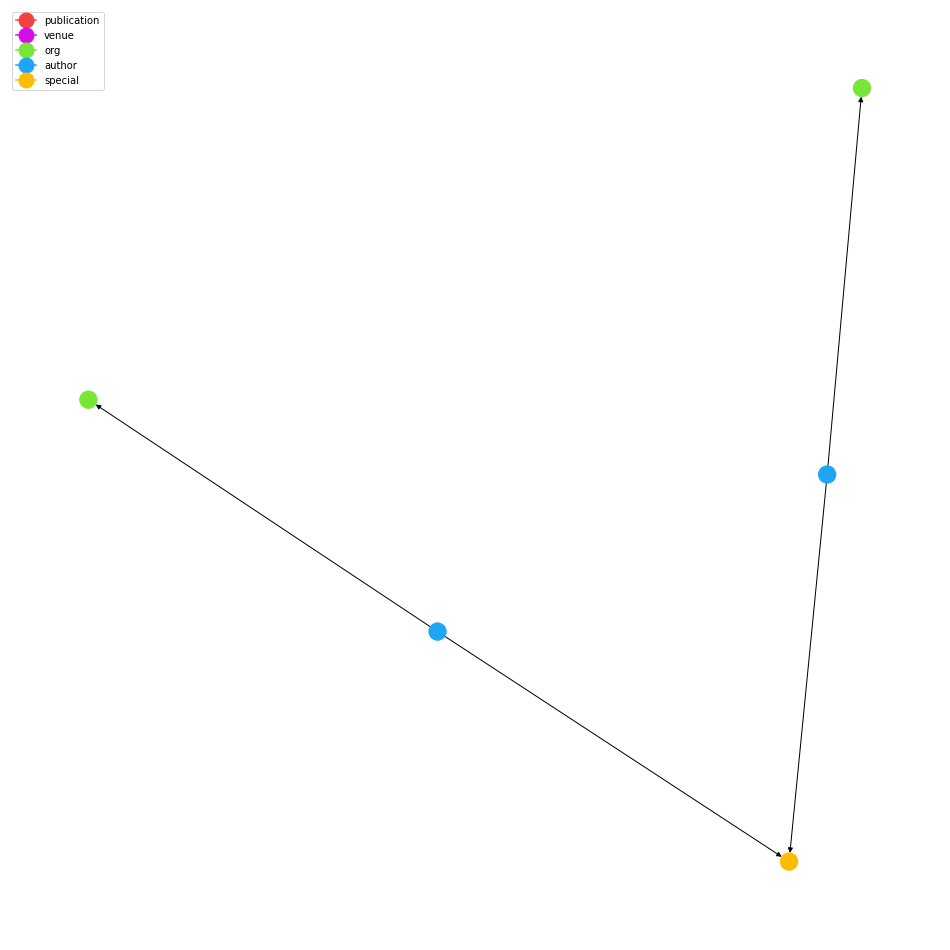

In [0]:
plot_graph(pub_orgs, ('e1', 'e2'), '53e99a0fb7602d9702263284') # Copy the publication ID from the previous cell

We can see that this publication has at least two authors; each work (or have worked) for a separate organization.

**Given a Venue ID, find all authors who have been hosted by that venue.**

In [0]:
hosted_author = (_graph
                 .find('(a)-[e1]->(b); (c)-[e2]->(b)')
                 .filter("c.Type = 'author' and a.id != c.id and a.id = '53a72dfa20f7420be8c7a2e9'"))

In [0]:
display(hosted_author)

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


a,e1,b,c,e2
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99796b7602d9701f5c118)","List(53e99796b7602d9701f5c118, publication, Performance Evaluation of a Steganographic Method for Digital Images Using Side Match)","List(53f436aedabfaedd74da3090, author, Suk-Ling Li)","List(53f436aedabfaedd74da3090, isAuthorOf, 53e99796b7602d9701f5c118)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99796b7602d9701f5c118)","List(53e99796b7602d9701f5c118, publication, Performance Evaluation of a Steganographic Method for Digital Images Using Side Match)","List(53f43588dabfaee02acc2bf2, author, Kai-Chi Leung)","List(53f43588dabfaee02acc2bf2, isAuthorOf, 53e99796b7602d9701f5c118)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99796b7602d9701f5c118)","List(53e99796b7602d9701f5c118, publication, Performance Evaluation of a Steganographic Method for Digital Images Using Side Match)","List(53f42dd3dabfaeb22f40e049, author, L. M. Cheng)","List(53f42dd3dabfaeb22f40e049, isAuthorOf, 53e99796b7602d9701f5c118)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99796b7602d9701f5c118)","List(53e99796b7602d9701f5c118, publication, Performance Evaluation of a Steganographic Method for Digital Images Using Side Match)","List(53f44b34dabfaec09f1dc245, author, Chi-Kwong Chan)","List(53f44b34dabfaec09f1dc245, isAuthorOf, 53e99796b7602d9701f5c118)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99a6db7602d97022debf9)","List(53e99a6db7602d97022debf9, publication, Optimal Design of Microgripper)","List(53f43b2cdabfaedf435adbb3, author, Shyh-Chour Huang)","List(53f43b2cdabfaedf435adbb3, isAuthorOf, 53e99a6db7602d97022debf9)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99a6db7602d97022debf9)","List(53e99a6db7602d97022debf9, publication, Optimal Design of Microgripper)","List(53f46bf3dabfaeb22f55455c, author, Chi-Ming Lee)","List(53f46bf3dabfaeb22f55455c, isAuthorOf, 53e99a6db7602d97022debf9)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99a3cb7602d970229b58f)","List(53e99a3cb7602d970229b58f, publication, A Robust Speech Recognition Based on the Feature of Weighting Combination ZCPA)","List(5602812045cedb3395fbe174, author, Xueying Zhang)","List(5602812045cedb3395fbe174, isAuthorOf, 53e99a3cb7602d970229b58f)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e99a3cb7602d970229b58f)","List(53e99a3cb7602d970229b58f, publication, A Robust Speech Recognition Based on the Feature of Weighting Combination ZCPA)","List(53f43804dabfaeecd696dc2f, author, Wuzhou Liang)","List(53f43804dabfaeecd696dc2f, isAuthorOf, 53e99a3cb7602d970229b58f)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e998a2b7602d97020db110)","List(53e998a2b7602d97020db110, publication, Model-Driven Development of Real-Time Software Based on OMG Standards)","List(53f45b51dabfaee02ad6b03b, author, Junli Gao)","List(53f45b51dabfaee02ad6b03b, isAuthorOf, 53e998a2b7602d97020db110)"
"List(53a72dfa20f7420be8c7a2e9, venue, International Conference on Innovative Computing, Information and Control)","List(53a72dfa20f7420be8c7a2e9, hosts, 53e998a2b76

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


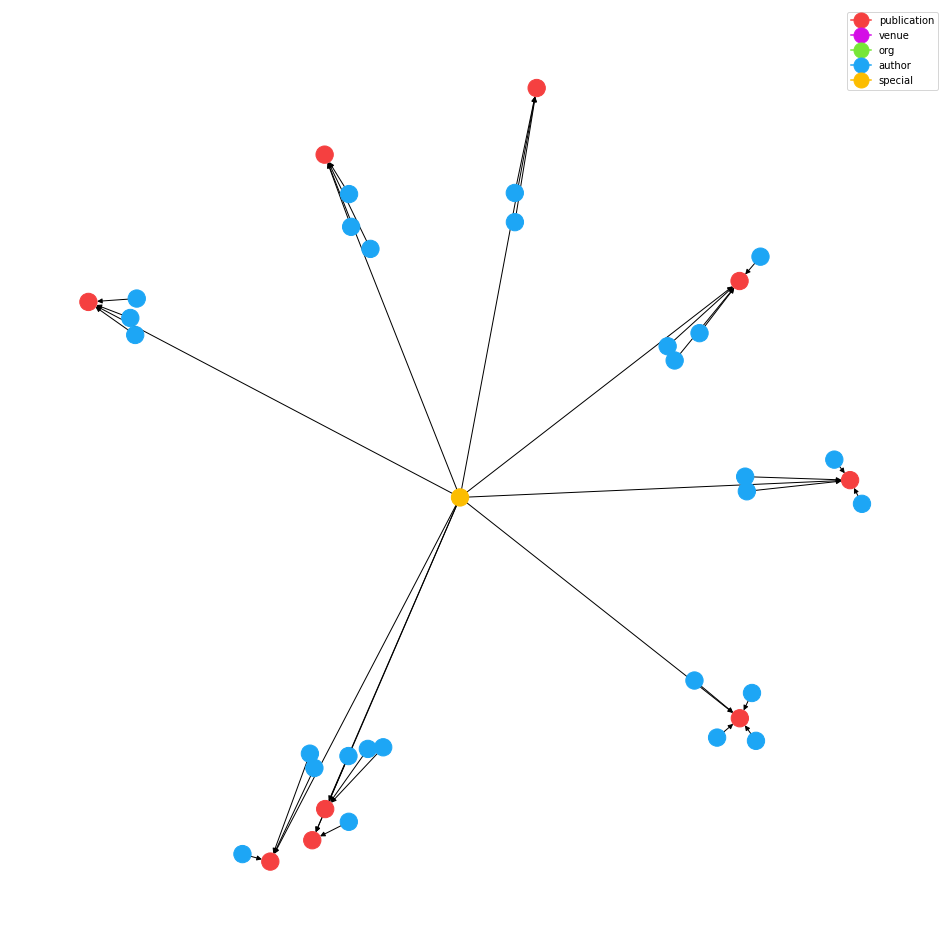

In [0]:
plot_graph(hosted_author, ('e1', 'e2'), '53a72dfa20f7420be8c7a2e9')

Given that a venue hosts publications, from this we can see the number of authors who've been hosted by that venue through their publications

### Analytics

**PageRank**

In [0]:
pageRank = _graph.pageRank(resetProbability=0.15, maxIter=10)

lim_print(pageRank.vertices.sort('pageRank', ascending=False))

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


id,Type,Name,pagerank
53e99b0ab7602d970239b0e3,publication,Recognition Using Region Correspondences,2055.4203283036177
53e9986eb7602d97020ab93b,publication,Distinctive Image Features from Scale-Invariant Keypoints,360.9336429840102
53e99a4eb7602d97022b29be,publication,An Overview of AspectJ,320.8531629525286
53e99a4eb7602d97022ae4c5,publication,A logic of authentication,313.9521390084815
53e9997eb7602d97021c01d8,publication,Probabilistic checking of proofs: a new characterization of NP,297.69275818228954
53e997f1b7602d9701ff150a,publication,Aspect-oriented programming,279.9651916900317
53e99a92b7602d9702307c6d,publication,Improved non-approximability results,218.64661709066442
53e99822b7602d970204503f,publication,Support-Vector Networks,192.56203919013694
53e99960b7602d97021a5260,publication,Random early detection gateways for congestion avoidance,183.19542334760646
53e99858b7602d970208f024,publication,The FC2TOOLS Set,180.8570135276709


The highest-ranking vertices are all publications. Makes sense since they have 3 sources - venues, authors, other publications - of incoming edges. With these parameters, we have one paper with a rank of over 2000 while the next most influential papers are in the hundreds.

**Connected components**

In [0]:
#Connected component membership of each node
sc.setCheckpointDir("/tmp/cc-checkpoint-dir") #Connected Components algorithm requires setting a Spark checkpoint directory to improve performance
cc = _graph.connectedComponents()

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


In [0]:
lim_print((cc.where("component != 0").orderBy(F.desc("component"))))

id,Type,Name,component
53e999b4b7602d97021f9ebf,publication,Evolution of a user interface design: NCR's management discovery tool (MDT),34359758087
53f45616dabfaec09f20571a,author,James F. Knutson,34359758087
53f43275dabfaee02aca134f,author,Richard L. Henneman,34359758087
5f71b2b11c455f439fe3d93f,org,"NCR, Gateway 2000, 610 Gateway Drive W-29, North Sioux City, SD",34359758087
53f438cedabfaec09f194061,author,Tej Anand,34359758087
53907b3e20f770854f5e7c6e,venue,Human Factors in Computing Systems,34359758087
5390795020f770854f5b658f,venue,Discrete Mathematics,25769832585
53f43575dabfaedf43577a1a,author,C. V. Venkatachalam,25769832585
5f71b3381c455f439fe41562,org,"Karnatak Univ., India",25769832585
5405947adabfae8faa5e4af7,author,E. Sampathkumar,25769832585


**BFS**

Given an author ID and some publication ID, see if the author directly (or indirectly) cites that publication.

In [0]:
bfs = _graph.bfs(fromExpr = 'id = "53f43296dabfaeb1a7bcd9fa"', # Put author ID here
                 toExpr = 'id = "53e9983db7602d9702068461"') # Put publication ID here

display(bfs)

from,e0,v1,e1,to
"List(53f43296dabfaeb1a7bcd9fa, author, Vittorio Ferrari)","List(53f43296dabfaeb1a7bcd9fa, isAuthorOf, 53e997ddb7602d9701fd5a8d)","List(53e997ddb7602d9701fd5a8d, publication, Localizing objects while learning their appearance)","List(53e997ddb7602d9701fd5a8d, cites, 53e9983db7602d9702068461)","List(53e9983db7602d9702068461, publication, Learning to Segment)"


We can see that this author does indirectly cite that paper.

**In-degrees of Vertices**

Compute the in-degree of each node in our graph

In [0]:
inDeg = (_graph.inDegrees
        .join(_graph.vertices, on = ['id'])
        .sort('inDegree', ascending = False))

In [0]:
lim_print(inDeg)

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


id,inDegree,Type,Name
5f71b5c41c455f439fe532ea,827,org,"IBM China Research Lab, Haidian District, Beijing, P. R. China"
5f71b2811c455f439fe3c5cb,729,org,"Ericsson d.o.o., Belgrade"
5f71b2861c455f439fe3c771,690,org,"Carnegie Mellon University, 5000 Forbes Ave., Pittsburgh PA"
5f71b28b1c455f439fe3c989,630,org,"Beijing Normal Univ, Sch Informat Sci & Technol, Beijing 100875, Peoples R China"
5f71b2841c455f439fe3c67b,567,org,"Department of Electrical Engineering, Stanford University, Stanford, CA"
5f71b2831c455f439fe3c634,511,org,"Microsoft Research, Redmond, WA"
5f71b29a1c455f439fe3d023,459,org,INRIA Sophia Antipolis - Orion Team
5f71b2841c455f439fe3c6b7,454,org,UC Berkeley Space Sciences Laboratory
5f71b2831c455f439fe3c633,445,org,MIT
5f71b5e01c455f439fe53f9a,443,org,"Department of Industrial and Systems Engineering, National University of Singapore, 1 Engineering Drive 2, Singapore 117576, Singapore"


**Out-degrees of vertices**

In [0]:
outs = (_graph
        .outDegrees
        .join(_graph.vertices, on = ['id'])
        .sort('outDegree', ascending = False))

lim_print(outs)

id,outDegree,Type,Name
53e9982cb7602d97020543f2,1860,publication,Picture Processing: 1981
0302-9743,1302,venue,Lecture Notes in Computer Science
53e9982cb7602d97020543f0,1219,publication,Picture processing: 1985.
53e999f4b7602d970223915c,742,publication,Computer graphics and CAD literature - a keyword-indexed biography
555036f57cea80f954169e28,678,venue,Communications of The ACM
53e9982cb7602d97020543f1,563,publication,Picture processing: 1984
53e99842b7602d970206b23e,560,publication,Metaheuristics: A bibliography
555036b87cea80f95414c3bf,543,venue,Conference on Combinatorial Optimization and Applications
53e997e4b7602d9701fdd4e5,518,publication,Bibliography on cyclostationarity
53a7293020f7420be8bca4fd,512,venue,Human Factors in Computing Systems


**Triangle count**

In [0]:
#Compute number of triangles passing through each node
triangle_count = (_graph
                  .triangleCount()
                  .sort('count', ascending = False))

lim_print(triangle_count)

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


count,id,Type,Name
316,555036f67cea80f95416a9f4,venue,International Conference on Computer Graphics and Interactive Techniques
121,53e99a4eb7602d97022b29be,publication,An Overview of AspectJ
118,53e9983db7602d97020698e6,publication,Light field rendering
114,54824fa4582fc50b5e02e699,venue,IEEE Transactions on Information Theory
97,53e9982cb7602d97020543f2,publication,Picture Processing: 1981
89,53e997f1b7602d9701ff150a,publication,Aspect-oriented programming
86,555036b77cea80f95414b7e3,venue,Information Sciences
84,53e9986eb7602d97020ab93b,publication,Distinctive Image Features from Scale-Invariant Keypoints
83,53e9983db7602d9702065035,publication,Latent dirichlet allocation
79,53a7256420f7420be8b4e0aa,venue,Computer Vision and Pattern Recognition


**Triplets**

In [0]:
triplets = _graph.triplets

lim_print(triplets)
logger.info(f'There are {triplets.count()} triplets.')

src,edge,dst
"List(54096bf9dabfae8faa68e261, author, Lan Wang)","List(54096bf9dabfae8faa68e261, isAuthorOf, 53e99792b7602d9701f5b2bc)","List(53e99792b7602d9701f5b2bc, publication, Persistent detection and recovery of state inconsistencies)"
"List(548a7e4ddabfaed7b5fa41f6, author, Wan L Lam)","List(548a7e4ddabfaed7b5fa41f6, isAuthorOf, 53e99792b7602d9701f5b2c7)","List(53e99792b7602d9701f5b2c7, publication, A stepwise framework for the normalization of array CGH data.)"
"List(5434bc64dabfaebba585dd09, author, Mérouane Debbah)","List(5434bc64dabfaebba585dd09, isAuthorOf, 53e99792b7602d9701f5b35d)","List(53e99792b7602d9701f5b35d, publication, Power allocation games in wireless networks of multi-antenna terminals)"
"List(53f391a4dabfae4b34a58998, author, Pengcheng Fan)","List(53f391a4dabfae4b34a58998, isAuthorOf, 53e99792b7602d9701f5b3e5)","List(53e99792b7602d9701f5b3e5, publication, A Method of Multiple-Marker Register and Application on Virtual Education.)"
"List(542a16aedabfaec7081dce4b, author, Mingquan Zhou)","List(542a16aedabfaec7081dce4b, isAuthorOf, 53e99792b7602d9701f5b3e5)","List(53e99792b7602d9701f5b3e5, publication, A Method of Multiple-Marker Register and Application on Virtual Education.)"
"List(5448dbe3dabfae87b7e8858c, author, Athena Vakali)","List(5448dbe3dabfae87b7e8858c, isAuthorOf, 53e99792b7602d9701f5b420)","List(53e99792b7602d9701f5b420, publication, The Dynamics of Content Popularity in Social Media)"
"List(548e5b05dabfaef989f09339, author, Ka Hin Leung)","List(548e5b05dabfaef989f09339, isAuthorOf, 53e99792b7602d9701f5b452)","List(53e99792b7602d9701f5b452, publication, Circulant weighing matrices of weight 22t)"
"List(548cb4a9dabfae9b40135489, author, Akira Yajima)","List(548cb4a9dabfae9b40135489, isAuthorOf, 53e99796b7602d9701f5bf05)","List(53e99796b7602d9701f5bf05, publication, A passive weight compensation mechanism with a non-circular pulley and a spring)"
"List(53f4b434dabfaedce5648757, author, Martin Bokeloh)","List(53f4b434dabfaedce5648757, isAuthorOf, 53e99796b7602d9701f5c157)","List(53e99796b7602d9701f5c157, publication, Special Section: Point-Based Graphics: Processing and interactive editing of huge point clouds from 3D scanners)"
"List(542a5f8fdabfae61d49734e0, author, Wen-Feng Chen)","List(542a5f8fdabfae61d49734e0, isAuthorOf, 53e99796b7602d9701f5c55e)","List(53e99796b7602d9701f5c55e, publication, The evaluative criteria of computer-based vocabulary learning games)"


INFO:__main__:There are 417156 triplets.
